<a href="https://colab.research.google.com/github/thedavidemmanuel/chatbot-with-transformers/blob/main/gitbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

#### This notebook details the development of a domain-specific Question Answering (QA) bot leveraging BERT (Bidirectional Encoder Representations from Transformers), a model that enhances the understanding of context in conversational language. Using a dataset from Kaggle, which includes questions, answers, and question patterns in a CSV format, the project aims to fine-tune BERT to accurately respond to domain-specific inquiries. This approach seeks to harness BERT's contextual processing capabilities to achieve precise answers, making the bot a valuable informational resource within its specified field.

# 1. Import Required Libraries

In [4]:
# Importing the Required Libraries
import numpy as np
import pandas as pd
import json
import pickle
import random
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/israelsmart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/israelsmart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Load and Explore Data

In [6]:
# Load and Explore Data
print("Loading dataset...")
df = pd.read_csv("data/gitbotdataset.csv")
print ("dataset loaded")

df.head()

Loading dataset...
dataset loaded


,Intent,Example User Input,Bot Response
0,greetings,"""Hi""","""Hello! How can I help you with GitHub?"""
1,greetings,"""Good morning""","""Good morning! What can I assist you with today?"""
2,greetings,"""Good evening""","""Good evening! Need help with GitHub?"""
3,greetings,"""Howdy""","""Hey! How can I help you today?"""
4,greetings,"""Greetings""","""Greetings! What brings you here?"""


## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Intent              341 non-null    object
 1   Example User Input  341 non-null    object
 2   Bot Response        341 non-null    object
dtypes: object(3)
memory usage: 8.1+ KB
Total samples: 341

Missing values in each column:
Intent                0
Example User Input    0
Bot Response          0
dtype: int64


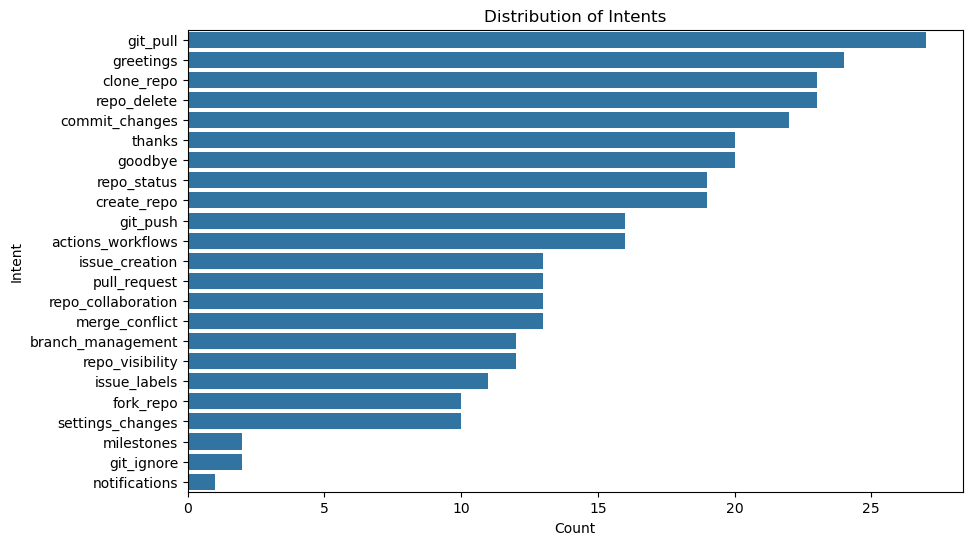

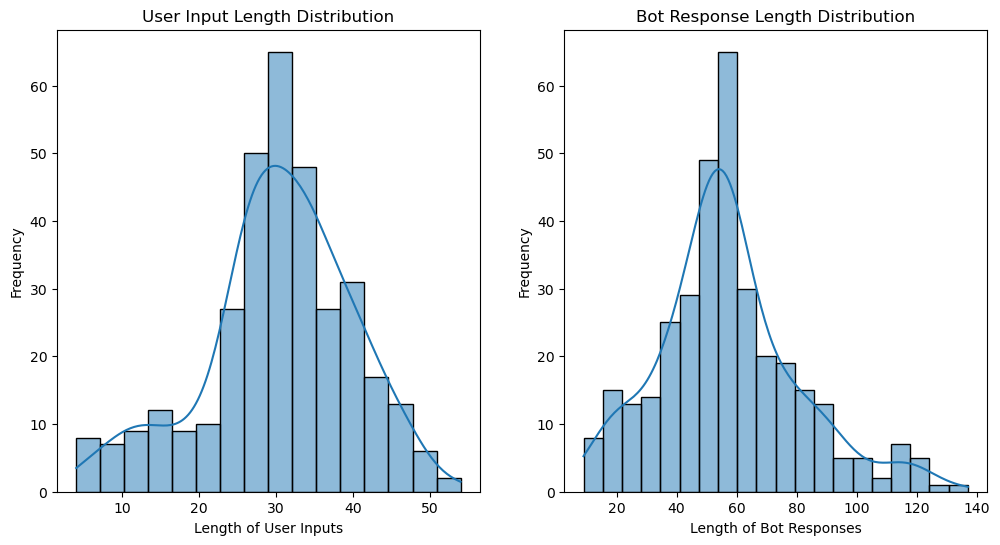

In [8]:
# Doing the most basic EDA on my data
df.info()
print(f"Total samples: {len(df)}")


# Checking for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of Intents
plt.figure(figsize=(10, 6))
sns.countplot(y='Intent', data=df, order = df['Intent'].value_counts().index)
plt.title('Distribution of Intents')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.show()

# Analyze the length of the Example User Inputs and Bot Responses
df['input_length'] = df['Example User Input'].apply(len)
df['response_length'] = df['Bot Response'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['input_length'], kde=True)
plt.title('User Input Length Distribution')
plt.xlabel('Length of User Inputs')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['response_length'], kde=True)
plt.title('Bot Response Length Distribution')
plt.xlabel('Length of Bot Responses')
plt.ylabel('Frequency')
plt.show()

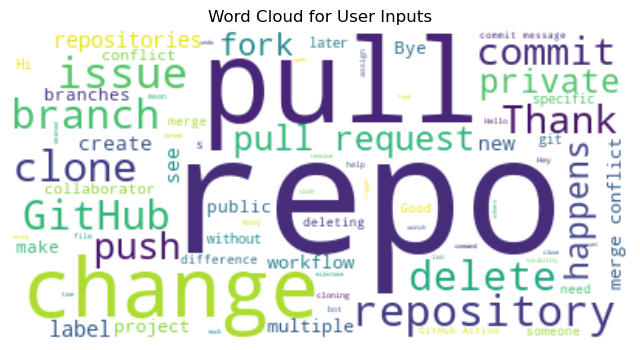

In [9]:
#Doing a wordcloud
# !pip install wordcloud ---run this line if you don't have wordcloud
from wordcloud import WordCloud

# Generating a word cloud for user inputs
input_text = " ".join(input for input in df['Example User Input'])
wordcloud = WordCloud(background_color='white').generate(input_text)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for User Inputs')
plt.show()

# 3. Data Preprocessing

In [11]:
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print("\nPreprocessing data...")

# Initialize BERT tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Initialize lists for collecting data
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

# Text normalization and lemmatization function
def clean_text(text):
    # Lowercasing and removing special characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Removing stop words and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Create intents dictionary and preprocess texts
dict_ = {"intents": []}
for _, row in df.iterrows():
    processed_input = clean_text(row['Example User Input'].strip('"'))
    processed_response = clean_text(row['Bot Response'].strip('"'))
    dict1 = {
        'tags': [row['Intent']],
        'patterns': [processed_input],
        'responses': [processed_response]
    }
    dict_['intents'].append(dict1)
    words.extend(nltk.word_tokenize(processed_input))  # Add processed words to the words list
    documents.append((processed_input, row['Intent']))  # Collect tuples of pattern and intent
    if row['Intent'] not in classes:
        classes.append(row['Intent'])  # Collect unique intents

# Deduplicate words list
words = sorted(list(set(words)))

# Save intents
with open("github_intents.json", "w") as f:
    json.dump(dict_, f, indent=4)

print("Preprocessing complete and data saved.")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/israelsmart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/israelsmart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/israelsmart/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Preprocessing data...
Preprocessing complete and data saved.


# 4. Feature Extraction using BERT

In [13]:
# Feature Extraction using BERT

def get_bert_embedding(sentence):
    """Extract BERT embeddings for a given sentence"""
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Process intents
for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

# Lemmatize and sort words
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

# Save preprocessed data
pickle.dump(words, open('github_words.pkl', 'wb'))
pickle.dump(classes, open('github_classes.pkl', 'wb'))

# 5. Prepare Training Data

In [15]:
# Prepare Training Data


training = []
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

# Split data into features and labels
X = np.array([item[0] for item in training])
y = np.array([item[1] for item in training])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data has been prepared and splited!")

Data has been prepared and splited!


# 6. Model Architecture

In [17]:
# Model Architecture

print("\nBuilding model...")
model = Sequential()
model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(y_train[0]), activation='softmax'))

# Learning rate schedule for better convergence
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compile model with multiple metrics
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

print("\nModel Summary:")
model.summary()



Building model...

Model Summary:


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,183 (422.59 KB)

 Trainable params: 108,183 (422.59 KB)

 Non-trainable params: 0 (0.00 B)

# 7. Model Training

In [19]:
# Model Training

print("\nTraining model...")
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=12,
                   validation_data=(X_val, y_val),
                   verbose=1)


Training model...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1024 - loss: 3.0455 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4599 - val_loss: 2.2616
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - Precision: 0.8210 - Recall: 0.0722 - accuracy: 0.4290 - loss: 2.1423 - val_Precision: 0.9545 - val_Recall: 0.3066 - val_accuracy: 0.6569 - val_loss: 1.4496
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - Precision: 0.9472 - Recall: 0.3245 - accuracy: 0.6073 - loss: 1.4405 - val_Precision: 0.9500 - val_Recall: 0.5547 - val_accuracy: 0.7445 - val_loss: 0.9603
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - Precision: 0.9232 - Recall: 0.4917 - accuracy: 0.7305 - loss: 1.0303 - val_Precision: 0.9419 - val_Recall: 0.5912 - val_accuracy: 0.7591 - val_loss: 0.8000
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - Precision: 0.8729 - Recall: 0.6020 - accuracy: 0.7374 - loss: 0.8667 - va

# 8. Evaluating the Model


Evaluating model...


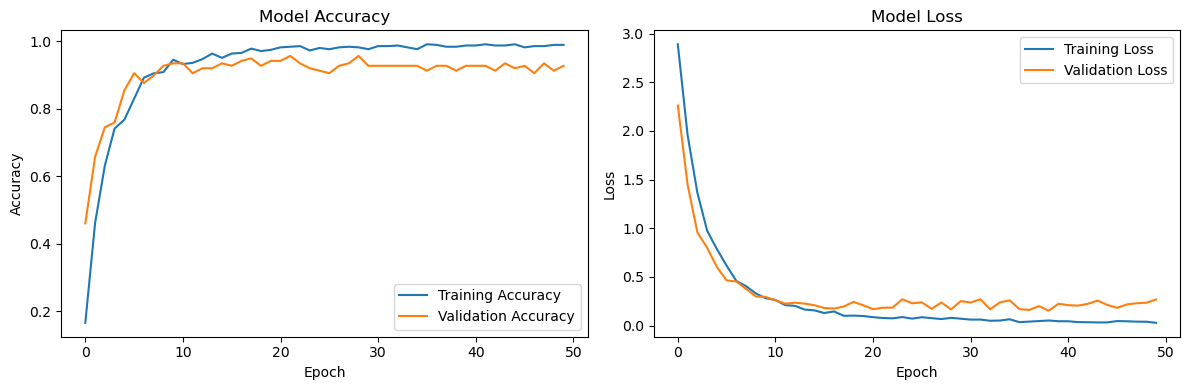

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Validation Metrics:
Accuracy: 0.9270
F1 Score: 0.9292


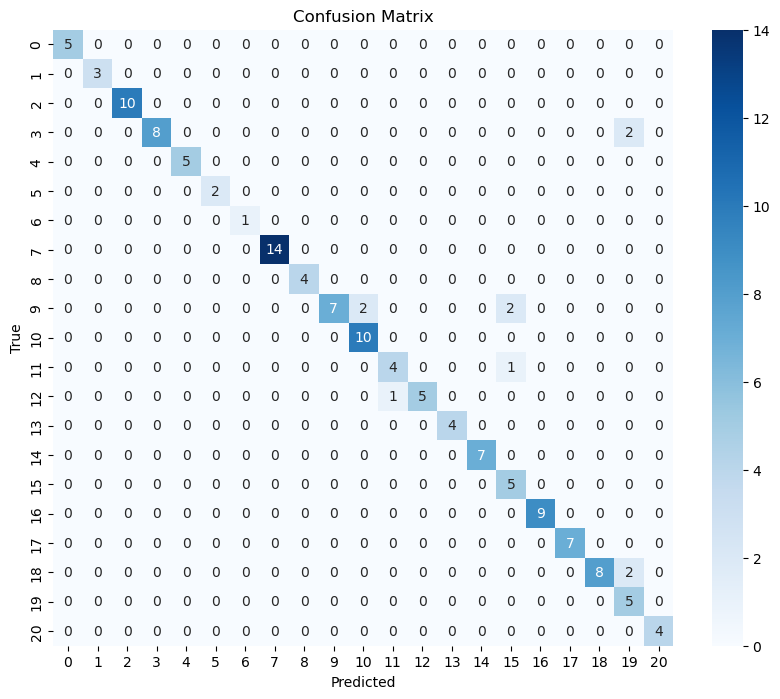

In [21]:
# Model Evaluation

print("\nEvaluating model...")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate validation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

print("\nValidation Metrics:")
print(f"Accuracy: {accuracy_score(y_val_classes, y_pred_classes):.4f}")
print(f"F1 Score: {f1_score(y_val_classes, y_pred_classes, average='weighted'):.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9. Save Model

In [23]:
# Save Model

model.save('github_chatbot_model.h5')
print("\nModel has been saved!")


Model has been saved!


# 10. Chatbot Interface

In [25]:
# Chatbot Interface

def predict_class(sentence):
    """Predict the intent class of a given sentence"""
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    """Get appropriate response based on predicted intent"""
    if not intents_list:
        return "I'm not sure how to help with that. Could you rephrase your question?"
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "I don't understand. Could you try asking in a different way?"

11. Interactive Testing


In [ ]:
# Interactive Testing

print("\nGitHub ChatBot is Active (type 'quit' to exit)")
print("Example queries:")
print("- How do I create a repository?")
print("- What is a pull request?")
print("- How do I fork a repository?")

while True:
    message = input("\nYou: ")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye!")
        break

    ints = predict_class(message)
    response = get_response(ints, dict_)
    print(f"Bot: {response}")

    # Log confidence scores for analysis
    if ints:
        print(f"Confidence: {float(ints[0]['probability']):.2%}")


GitHub ChatBot is Active (type 'quit' to exit)
Example queries:
- How do I create a repository?
- What is a pull request?
- How do I fork a repository?
